# Programming Project #2: Image Quilting

## CS445: Computational Photography


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time

# modify to where you store your project data including utils.py
datadir = "C:/Users/leahl/Classes/CS445/quilting/"

utilfn = datadir + "utils.py"
samplesfn = datadir + "samples"

# !cp "$utilfn" .
# !cp -r "$samplesfn" .

import utils

In [2]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [3]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    
    # convert sample from uint8 to float32 (needs to be [0, 1] for floating point)
    sample = sample.astype(np.float32) / 255.0 
    sample_height = np.shape(sample)[0]
    sample_width = np.shape(sample)[1]
    
    # initialize texture to be all zeros
    texture = np.zeros((out_size, out_size, 3), dtype=np.float32)
    
    # loop through possible patches in texture ... (r, c) = top left corner of patch
    for r in range(0, out_size - patch_size + 1, patch_size):
        for c in range(0, out_size - patch_size + 1, patch_size):
            
            # choose random patch in sample
            i = (int) (random()*(sample_height - patch_size))
            j = (int) (random()*(sample_width - patch_size))
            
            # set patch in texture 
            patch = sample[i:i+patch_size, j:j+patch_size, :]
            texture[r:r+patch_size, c:c+patch_size, :] = patch
    
    return texture

(106, 108, 3)


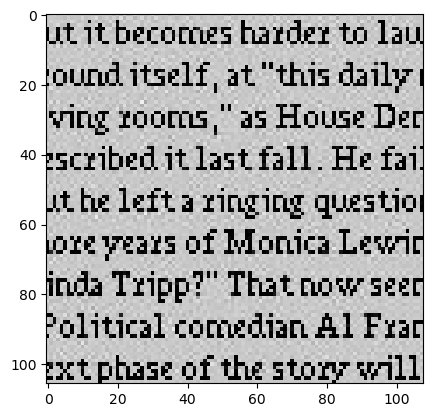

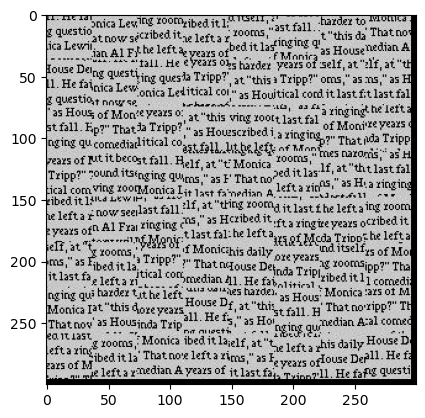

In [23]:
sample_img_fn = 'samples/text_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)

print(sample_img.shape)
sample_img = cv2.resize(sample_img, (250, 250))
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 37
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [6]:
def ssd_patch(sample, template, mask, patch_size):
    """
    Performs template matching with the overlapping region, computing the cost of sampling each patch, 
    based on the sum of squared differences (SSD) of the overlapping regions of the existing and sampled patch
    :param sample: numpy.ndarray (height, width, channels) ... channels = 3 for RGB
    :param template: numpy.ndarray (patch_size, patch_size, channels)
    :param mask: numpy.ndarray (patch_size, patch_size, 1)
    :param patch_size: int
    :return: numpy.ndarray (height, width)
    """
    
    sample_height, sample_width, channels = sample.shape
    
    # initialize ssd cost image with zeros
    ssd_costs = np.zeros((sample_height, sample_width))
    
    # compute SSD cost for each channel
    for c in range(channels):
        T = template[:, :, c]
        M = mask[:, :, c]
        I = sample[:, :, c].copy()

        cost = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
        ssd_costs += cost
    
    # set borders of ssd cost image to inf (so only templates fully within bounds are selected)
    half = patch_size // 2
    ssd_costs[:half, :] = np.inf
    ssd_costs[-half:, :] = np.inf
    ssd_costs[:, :half] = np.inf
    ssd_costs[:, -half:] = np.inf
    
    return ssd_costs

In [7]:
def choose_sample(ssd_costs, tol):
    """
    Selects a randomly sampled patch from the tol lowest in ssd_costs
    :param ssd_costs: numpy.ndarray (height, width)
    :param tol: float
    :return: int, int 
    """
    
    # flatten the 2D array to 1D and sort (returns increasing sorted indices)
    flattened_costs = ssd_costs.flatten()
    sorted_costs = np.argsort(flattened_costs)
    
    # select random idx of the lowest tol indices
    selected_idx = (int) (random()*tol)
    
    # convert the index into the flattened_costs array back into the original 2D coords
    center_i, center_j = np.unravel_index(sorted_costs[selected_idx], ssd_costs.shape)
        
    return center_i, center_j

In [8]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    
    assert(patch_size % 2 == 1)
    
    # convert sample from uint8 to float32
    sample = sample.astype(np.float32) / 255.0 
    sample_height, sample_width, _ = np.shape(sample)
    half_patch = patch_size // 2
    
    # initialize texture to be all zeros
    texture = np.zeros((out_size, out_size, 3), dtype=np.float32)
    
    # loop through possible patches in texture, making sure to overlap
    for r in range(0, out_size - patch_size + 1, patch_size - overlap):
        for c in range(0, out_size - patch_size + 1, patch_size - overlap):
            
            # check if top left corner
            if r == 0 and c == 0:
                # sample random patch and set in texture
                i = (int) (random()*(sample_height - patch_size))
                j = (int) (random()*(sample_width - patch_size))

                patch = sample[i:i+patch_size, j:j+patch_size, :]
                texture[r:r+patch_size, c:c+patch_size, :] = patch

            # otherwise
            else:
                # get the current part of the new texture we want to fill in
                template = texture[r:r+patch_size, c:c+patch_size, :]
                
                # create mask of where there is overlap in the template 
                mask = np.zeros_like(template)
                if c > 0:
                    mask[:, :overlap, :] = 1
                    
                if r > 0:
                    mask[:overlap, :, :] = 1
                
                # compute the best sample coords from SSD costs
                ssd_costs = ssd_patch(sample, template, mask, patch_size)
                center_i, center_j = choose_sample(ssd_costs, tol)
                                
                # fill in the texture with this sampled image
                patch = sample[center_i-half_patch:center_i+half_patch+1, center_j-half_patch:center_j+half_patch+1, :].copy()
                texture[r:r+patch_size, c:c+patch_size, :] = patch
                
    return texture


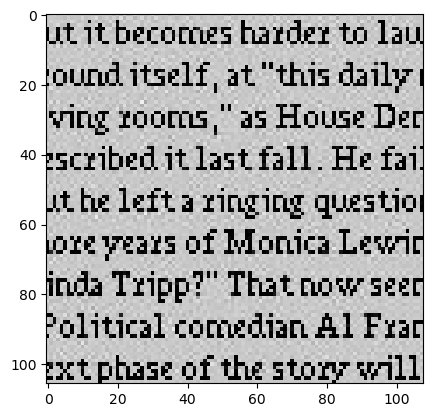

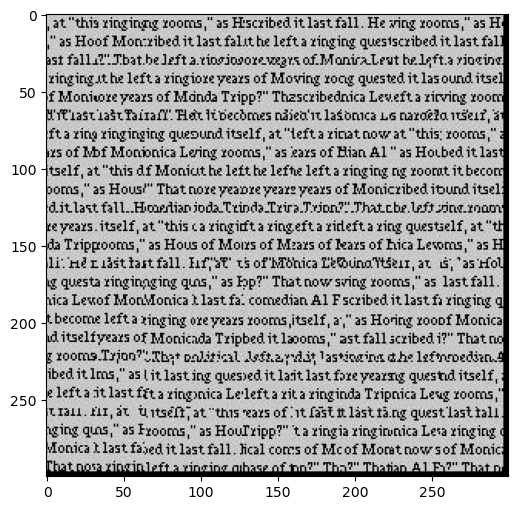

In [20]:
sample_img_fn = 'samples/text_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
# sample_img = cv2.resize(sample_img, (200, 200))
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 41
overlap = 9
tol = 5
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    plt.figure(figsize=(6,6))
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [24]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [119]:
def display_seams(images):
    # make list of titles for the graphs
    titles = ["Sample Top", "Template Top", "SSD Cost Top","Horiz Mask" ,
              "Sample Left", "Template Left", "SSD Cost Left", "Vert Mask",
              "Combination Mask"]
    
    # plot the images
    fig, axes = plt.subplots(3, 4, gridspec_kw={'height_ratios': [2, 1, 2]}, figsize=(6, 5))
    for i in range(2):
        idx = i * 4
        for j in range(4):
            axes[i, j].imshow(images[idx + j])
            axes[i, j].set_title(titles[idx + j])

    axes[2, 0] = plt.subplot2grid((3, 4), (2, 0), colspan=4)
    axes[2, 0].imshow(images[-1])
    axes[2, 0].set_title(titles[-1])

    plt.tight_layout()
    plt.show()
              

In [120]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    
    assert(patch_size % 2 == 1)
    
    # convert sample from uint8 to float32
    sample = sample.astype(np.float32) / 255.0 
    sample_height, sample_width, channels = np.shape(sample)
    half_patch = patch_size // 2
    
    # initialize texture to be all zeros
    texture = np.zeros((out_size, out_size, 3), dtype=np.float32)
    
    # loop through possible patches in texture, making sure to overlap
    z = 0
    for r in range(0, out_size - patch_size + 1, patch_size - overlap):
        for c in range(0, out_size - patch_size + 1, patch_size - overlap):
            z = z + 1
            # check if top left corner
            if r == 0 and c == 0:
                # sample random patch and set in texture
                i = (int) (random()*(sample_height - patch_size))
                j = (int) (random()*(sample_width - patch_size))

                patch = sample[i:i+patch_size, j:j+patch_size, :]
                texture[r:r+patch_size, c:c+patch_size, :] = patch

            # otherwise
            else:
                # get the current part of the new texture we want to fill in
                template = texture[r:r+patch_size, c:c+patch_size, :]
                
                # create mask of where there is overlap in the template 
                mask = np.zeros_like(template)
                if c > 0:
                    mask[:, :overlap, :] = 1
                    
                if r > 0:
                    mask[:overlap, :, :] = 1
                
                # compute the best sample coords from SSD costs
                ssd_costs = ssd_patch(sample, template, mask, patch_size)
                center_i, center_j = choose_sample(ssd_costs, tol)
                patch = sample[center_i-half_patch:center_i+half_patch+1, center_j-half_patch:center_j+half_patch+1, :].copy()
                
                ################
                # Seam Finding
                ################
                
                # get the overlaps from the texture (already filled in) and sampled patch
                patch_overlap_top = patch[:overlap, :, :]
                texture_overlap_top = texture[r:r+overlap, c:c+patch_size, :]
                
                patch_overlap_left = patch[:, :overlap, :]
                texture_overlap_left = texture[r:r+patch_size, c:c+overlap, :]
                
                # calculate errors and use them to compute the seam masks using cut            
                err_overlap_top = np.sum((texture_overlap_top - patch_overlap_top) ** 2, axis=2)
                err_overlap_left = np.sum((texture_overlap_left - patch_overlap_left) ** 2, axis=2)
                seam_top = cut(err_overlap_top)
                seam_left = cut(err_overlap_left.T).T
                
                # create masks for the top and left seams (0 = left/top, 1 = right/bottom)
                mask_top = np.ones((patch_size, patch_size), dtype=bool)
                mask_top[:overlap, :] = seam_top
                
                mask_left = np.ones((patch_size, patch_size), dtype=bool)
                mask_left[:, :overlap] = seam_left
                
                # create the final mask, combining top and left if necessary
                # ... 0 means keep from existing texture, 1 means use new sampled patch
                seam_mask = np.ones((patch_size, patch_size), dtype=bool)
                if r == 0:
                    seam_mask = mask_left
                elif c == 0:
                    seam_mask = mask_top
                else:
                    seam_mask = np.logical_and(mask_left, mask_top)
                
                # displaying the seams/masks
#                 if z == 50:
#                     display_seams([patch_overlap_top, texture_overlap_top, err_overlap_top, mask_top[:overlap, :],
#                                    patch_overlap_left, texture_overlap_left, err_overlap_left, mask_left[:, :overlap], seam_mask])

                ################
                # Seam Finding
                ################
                
                # fill in the texture with the masked sampled image
                texture_patch = texture[r:r+patch_size, c:c+patch_size, :]
                texture_patch[:,:,0] = np.where(seam_mask == 0, texture_patch[:,:,0], patch[:,:,0]) 
                texture_patch[:,:,1] = np.where(seam_mask == 0, texture_patch[:,:,1], patch[:,:,1]) 
                texture_patch[:,:,2] = np.where(seam_mask == 0, texture_patch[:,:,2], patch[:,:,2])
                
    return texture


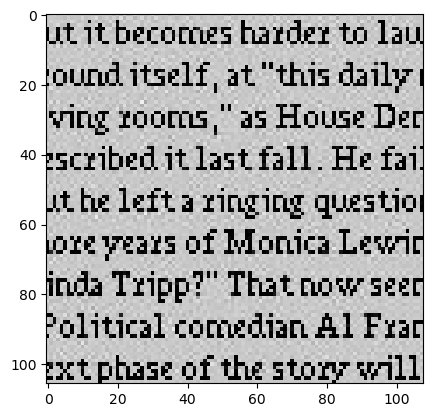

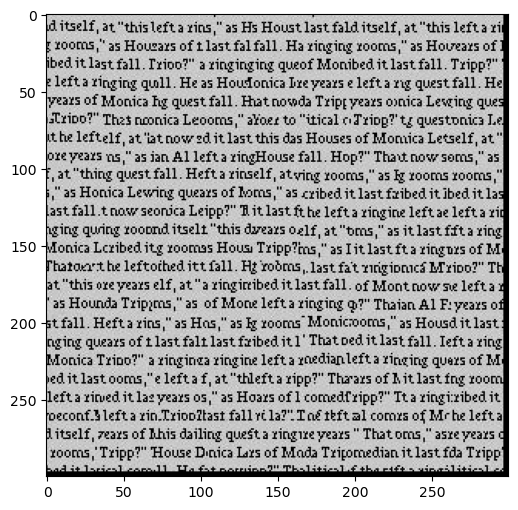

In [121]:
sample_img_fn = 'samples/text_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
# sample_img = cv2.resize(sample_img, (200, 200))
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 41
overlap = 9
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(6,6))
    plt.imshow(res)

### part IV: Texture Transfer (30 pts)

In [ ]:
def ssd_patch_transfer(sample, template, guidance, mask, patch_size):
    """
    Performs template matching with the overlapping region, computing the cost of sampling each patch, 
    based on the sum of squared differences (SSD) of the overlapping regions of the existing and sampled patch
    :param sample: numpy.ndarray (height, width, channels) ... channels = 3 for RGB
    :param template: numpy.ndarray (patch_size, patch_size, channels)
    :param mask: numpy.ndarray (patch_size, patch_size, 1)
    :param patch_size: int
    :return: numpy.ndarray (height, width)
    """
    
    sample_height, sample_width, channels = sample.shape
    
    # initialize ssd cost image with zeros
    ssd_costs = np.zeros((sample_height, sample_width))
    
    # compute SSD cost for each channel
    for c in range(channels):
        T = template[:, :, c]
        M = mask[:, :, c]
        I = sample[:, :, c].copy()

        cost = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
        ssd_costs += cost
    
    # set borders of ssd cost image to inf (so only templates fully within bounds are selected)
    half = patch_size // 2
    ssd_costs[:half, :] = np.inf
    ssd_costs[-half:, :] = np.inf
    ssd_costs[:, :half] = np.inf
    ssd_costs[:, -half:] = np.inf
    
    return ssd_costs

In [122]:
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    
    assert(patch_size % 2 == 1)
    
    # convert sample from uint8 to float32
    sample = sample.astype(np.float32) / 255.0 
    sample_height, sample_width, channels = np.shape(sample)
    half_patch = patch_size // 2
    
    # initialize texture to be all zeros
    texture = np.zeros((out_size, out_size, 3), dtype=np.float32)
    
    # loop through possible patches in texture, making sure to overlap
    z = 0
    for r in range(0, out_size - patch_size + 1, patch_size - overlap):
        for c in range(0, out_size - patch_size + 1, patch_size - overlap):
            z = z + 1
            # check if top left corner
            if r == 0 and c == 0:
                # sample random patch and set in texture
                i = (int) (random()*(sample_height - patch_size))
                j = (int) (random()*(sample_width - patch_size))

                patch = sample[i:i+patch_size, j:j+patch_size, :]
                texture[r:r+patch_size, c:c+patch_size, :] = patch

            # otherwise
            else:
                # get the current part of the new texture we want to fill in
                template = texture[r:r+patch_size, c:c+patch_size, :]
                
                # create mask of where there is overlap in the template 
                mask = np.zeros_like(template)
                if c > 0:
                    mask[:, :overlap, :] = 1
                    
                if r > 0:
                    mask[:overlap, :, :] = 1
                
                # compute the best sample coords from SSD costs
                ssd_costs = ssd_patch(sample, template, mask, patch_size)
                center_i, center_j = choose_sample(ssd_costs, tol)
                patch = sample[center_i-half_patch:center_i+half_patch+1, center_j-half_patch:center_j+half_patch+1, :].copy()
                
                ################
                # Seam Finding
                ################
                
                # get the overlaps from the texture (already filled in) and sampled patch
                patch_overlap_top = patch[:overlap, :, :]
                texture_overlap_top = texture[r:r+overlap, c:c+patch_size, :]
                
                patch_overlap_left = patch[:, :overlap, :]
                texture_overlap_left = texture[r:r+patch_size, c:c+overlap, :]
                
                # calculate errors and use them to compute the seam masks using cut            
                err_overlap_top = np.sum((texture_overlap_top - patch_overlap_top) ** 2, axis=2)
                err_overlap_left = np.sum((texture_overlap_left - patch_overlap_left) ** 2, axis=2)
                seam_top = cut(err_overlap_top)
                seam_left = cut(err_overlap_left.T).T
                
                # create masks for the top and left seams (0 = left/top, 1 = right/bottom)
                mask_top = np.ones((patch_size, patch_size), dtype=bool)
                mask_top[:overlap, :] = seam_top
                
                mask_left = np.ones((patch_size, patch_size), dtype=bool)
                mask_left[:, :overlap] = seam_left
                
                # create the final mask, combining top and left if necessary
                # ... 0 means keep from existing texture, 1 means use new sampled patch
                seam_mask = np.ones((patch_size, patch_size), dtype=bool)
                if r == 0:
                    seam_mask = mask_left
                elif c == 0:
                    seam_mask = mask_top
                else:
                    seam_mask = np.logical_and(mask_left, mask_top)
                
                ################
                # Seam Finding
                ################
                
                # fill in the texture with the masked sampled image
                texture_patch = texture[r:r+patch_size, c:c+patch_size, :]
                texture_patch[:,:,0] = np.where(seam_mask == 0, texture_patch[:,:,0], patch[:,:,0]) 
                texture_patch[:,:,1] = np.where(seam_mask == 0, texture_patch[:,:,1], patch[:,:,1]) 
                texture_patch[:,:,2] = np.where(seam_mask == 0, texture_patch[:,:,2], patch[:,:,2])
                
    return texture


In [123]:
# load/process appropriate input texture and guidance images

patch_size = 25
overlap = 11
tol = 3
alpha = 0.5
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(15,15))
plt.imshow(res)
plt.show()

NameError: name 'texture_img' is not defined

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).